Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)


# Latent Dirchilet Allocation Models (Learn)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [2]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [65]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Activity**: update the function `tokenize` with any technique you have learned so far this week. 

In [ ]:
# 1) Plain Python - ''.split command
# 2) Spacy - just the lemmas from the document
# 3) Gensim - simple_preprocess

def tokenize(text):
    "Complete this function"
    
    return tokens

In [15]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            with open(os.path.join(path,f)) as t:
                text = t.read().strip('\n')
                data.append(tokenize(str(text)))       
    return data

In [16]:
tokens = gather_data(path)

In [10]:
tokens[0][0:10]

['she',
 'found',
 'that',
 'he',
 'was',
 'only',
 'giving',
 'his',
 'fair',
 'companion']

In [14]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [12]:
df['tokens'].head()

Austen_Emma0026         [giving, fair, companion, account, yesterday, ...
Austen_Emma0032         [feels, like, snow, place, party, try, day, di...
CBronte_Villette0086    [pierced, opaque, blackness, stood, bougie, qu...
CBronte_Jane0099        [joke, queer, looks, tell, thing, specially, s...
CBronte_Villette0092    [second, landing, floor, comprising, abode, kn...
Name: tokens, dtype: object

## Follow Along

In [66]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [67]:
len(titles)

813

In [13]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [14]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

In [59]:
len(tokens)

813

### Author DataFrame


In [68]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [69]:
df.head()

,tokens
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ..."
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di..."
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu..."
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s..."
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn..."


ValueError: invalid literal for int() with base 10: 'ckpo'

In [65]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [66]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [16]:
df.author.value_counts()

0.0    441
1.0    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [28]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            with open(os.path.join(path,f)) as t:
                text = t.read().strip('\n')
                tokens = tokenize(str(text))
                yield tokens

In [29]:
streaming_data = doc_stream(path)

<generator object doc_stream at 0x1a21c23408>

### Gensim LDA Topic Modeling

In [31]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [34]:
id2word.token2id['jane']

932

In [35]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(869, 3), (1254, 1), (2485, 1), (16850, 1)]

In [36]:
import sys
sys.getsizeof(id2word)

56

In [37]:
len(id2word.keys())

22095

In [38]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=20, no_above=0.85)

In [39]:
len(id2word.keys())

2880

In [40]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [43]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=8
                  )

In [44]:
lda.print_topics()

[(0,
  '0.018*"elizabeth" + 0.012*"darcy" + 0.008*"bennet" + 0.007*"jane" + 0.007*"bingley" + 0.007*"miss" + 0.006*"know" + 0.006*"wickham" + 0.006*"sister" + 0.006*"soon"'),
 (1,
  '0.014*"play" + 0.009*"la" + 0.007*"paul" + 0.007*"read" + 0.007*"fresh" + 0.007*"ring" + 0.006*"good" + 0.006*"answer" + 0.006*"shall" + 0.006*"man"'),
 (2,
  '0.020*"elinor" + 0.016*"marianne" + 0.008*"sister" + 0.008*"edward" + 0.007*"mother" + 0.007*"dashwood" + 0.007*"time" + 0.007*"jennings" + 0.006*"willoughby" + 0.006*"know"'),
 (3,
  '0.036*"rochester" + 0.017*"adele" + 0.012*"sir" + 0.010*"fairfax" + 0.009*"room" + 0.009*"yes" + 0.007*"house" + 0.007*"hall" + 0.007*"ll" + 0.006*"gentlemen"'),
 (4,
  '0.022*"miss" + 0.021*"bessie" + 0.018*"reed" + 0.010*"little" + 0.010*"like" + 0.008*"think" + 0.008*"room" + 0.007*"sir" + 0.007*"georgiana" + 0.007*"child"'),
 (5,
  '0.021*"bingley" + 0.015*"elizabeth" + 0.013*"bennet" + 0.013*"miss" + 0.012*"jane" + 0.009*"know" + 0.008*"sister" + 0.008*"good" + 0

In [45]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [46]:
topics = [' '.join(t[0:5]) for t in words]

In [47]:
for t in topics: 
    print(t)
    print("\n")

elizabeth darcy bennet jane bingley


play la paul read fresh


elinor marianne sister edward mother


rochester adele sir fairfax room


miss bessie reed little like


bingley elizabeth bennet miss jane


reed child aunt eyre madam


little like john bretton eyes


know miss think jane like


little like madame thought know


emma miss weston jane thing


emma harriet miss think good


nature making brother little elder


hunsden crimsworth room like miss


like jane long night sir




## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [48]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [49]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.064486  0.028350       1        1  23.693871
14     0.084863 -0.025542       2        1  16.645670
11    -0.095917  0.015234       3        1  14.838421
2     -0.079380  0.026090       4        1  13.486469
0     -0.097761  0.030118       5        1  12.512311
7      0.097679 -0.008523       6        1   5.084409
10    -0.104458 -0.023021       7        1   4.916125
13     0.057979 -0.046341       8        1   2.394367
4      0.017139 -0.083435       9        1   2.147686
3      0.084363 -0.119768      10        1   1.708400
5     -0.118024  0.016862      11        1   1.206097
8     -0.083707 -0.040676      12        1   0.975688
6      0.039810  0.032011      13        1   0.214355
1      0.108596  0.141724      14        1   0.146349
12     0.024331  0.056917      15        1   0.029783, topic_info=     Category         Freq          Term        Total  loglift  logprob
818   Default  1523.000000          miss  1523.000000  30.0000  30.0000
143   Default  1727.000000        little  1727.000000  29.0000  29.0000
628   Default   940.000000          jane   940.000000  28.0000  28.0000
135   Default  1440.000000          know  1440.000000  27.0000  27.0000
407   Default  1313.000000         think  1313.000000  26.0000  26.0000
64    Default   840.000000          emma   840.000000  25.0000  25.0000
1157  Default   650.000000     elizabeth   650.000000  24.0000  24.0000
314   Default  1356.000000          good  1356.000000  23.0000  23.0000
338   Default  1338.000000          like  1338.000000  22.0000  22.0000
1765  Default   694.000000        elinor   694.000000  21.0000  21.0000
1778  Default   574.000000      marianne   574.000000  20.0000  20.0000
668   Default   376.000000     rochester   376.000000  19.0000  19.0000
533   Default   935.000000         shall   935.000000  18.0000  18.0000
408   Default  1327.000000          time  1327.000000  17.0000  17.0000
196   Default   898.000000          room   898.000000  16.0000  16.0000
1420  Default   297.000000       bingley   297.000000  15.0000  15.0000
220   Default  1151.000000       thought  1151.000000  14.0000  14.0000
145   Default   950.000000          long   950.000000  13.0000  13.0000
452   Default   587.000000          dear   587.000000  12.0000  12.0000
1433  Default   422.000000         darcy   422.000000  11.0000  11.0000
340   Default   909.000000           man   909.000000  10.0000  10.0000
219   Default   786.000000         thing   786.000000   9.0000   9.0000
157   Default   673.000000        mother   673.000000   8.0000   8.0000
865   Default   615.000000           sir   615.000000   7.0000   7.0000
204   Default   593.000000        sister   593.000000   6.0000   6.0000
102   Default   623.000000          hand   623.000000   5.0000   5.0000
1139  Default   321.000000        bennet   321.000000   4.0000   4.0000
209   Default   934.000000          soon   934.000000   3.0000   3.0000
825   Default   313.000000        nature   313.000000   2.0000   2.0000
426   Default   603.000000           yes   603.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
814   Topic15     0.401673        making   201.450729   1.9013  -5.2656
470   Topic15     0.090282        folded    45.372822   1.8993  -6.7583
2139  Topic15     0.235623       anxious   122.895287   1.8621  -5.7990
405   Topic15     0.184872        temper   118.071846   1.6596  -6.0416
803   Topic15     0.078805      informed    52.925007   1.6093  -6.8943
825   Topic15     0.444610        nature   313.435455   1.5608  -5.1640
1111  Topic15     0.105364        suffer    77.417137   1.5195  -6.6038
1006  Topic15     0.044169     accompany    32.689568   1.5122  -7.4732
1653  Topic15     0.030268        origin    22.614065   1.5027  -7.8512
1381  Topic15     0.027611    ridiculous    20.990719   1.4854  -7.9430
91    Topic15  

### Overall Model / Documents

In [50]:
lda[corpus[0]]

[(2, 0.123048306), (9, 0.024056682), (10, 0.39177036), (11, 0.45878816)]

In [51]:
distro = [lda[d] for d in corpus]

In [52]:
distro[0]

[(2, 0.12359037), (9, 0.02305902), (10, 0.3919671), (11, 0.459047)]

In [53]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [70]:
df.head()

,tokens
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ..."
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di..."
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu..."
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s..."
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn..."


In [72]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [73]:
df.head()

,elizabeth darcy bennet jane bingley,play la paul read fresh,elinor marianne sister edward mother,rochester adele sir fairfax room,miss bessie reed little like,bingley elizabeth bennet miss jane,reed child aunt eyre madam,little like john bretton eyes,know miss think jane like,little like madame thought know,emma miss weston jane thing,emma harriet miss think good,nature making brother little elder,hunsden crimsworth room like miss,like jane long night sir,author
Austen_Emma0026,0.0,0.0,0.122404,0.0,0.0,0.0,0.0,0.000000,0.0,0.025382,0.391558,0.458320,0.0,0.0,0.000000,Austen
Austen_Emma0032,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.118313,0.848318,0.0,0.0,0.030974,Austen
CBronte_Villette0086,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.977554,0.000000,0.000000,0.0,0.0,0.019659,CBronte
CBronte_Jane0099,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.996605,CBronte
CBronte_Villette0092,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.011721,0.0,0.956256,0.000000,0.025141,0.0,0.0,0.000000,CBronte


In [74]:
df.groupby('author').mean()

,elizabeth darcy bennet jane bingley,play la paul read fresh,elinor marianne sister edward mother,rochester adele sir fairfax room,miss bessie reed little like,bingley elizabeth bennet miss jane,reed child aunt eyre madam,little like john bretton eyes,know miss think jane like,little like madame thought know,emma miss weston jane thing,emma harriet miss think good,nature making brother little elder,hunsden crimsworth room like miss,like jane long night sir
author,,,,,,,,,,,,,,,
Austen,0.271615,0.000000,0.268995,0.001121,0.001612,0.025531,0.000000,0.003694,0.016675,0.003418,0.099252,0.287683,0.000000,0.003514,0.013887
CBronte,0.007054,0.002261,0.008968,0.032202,0.039269,0.000099,0.003807,0.088555,0.003254,0.433791,0.000659,0.021061,0.000183,0.042458,0.313301


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [75]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [76]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

Process ForkPoolWorker-721:
Process ForkPoolWorker-724:
Process ForkPoolWorker-722:
Process ForkPoolWorker-723:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/pyt

In [123]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

NameError: name 'coherencemodel' is not defined

In [124]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.935416,2,0
1,-0.939436,8,0
2,-0.952264,14,0
3,-0.912855,20,0
4,-0.905050,26,0


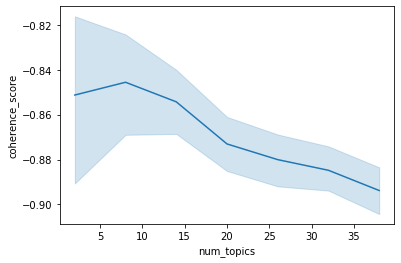

In [125]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [76]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2785
Num Topics = 8  has Coherence Value of 0.3029
Num Topics = 14  has Coherence Value of 0.2887
Num Topics = 20  has Coherence Value of 0.2852
Num Topics = 26  has Coherence Value of 0.2846
Num Topics = 32  has Coherence Value of 0.2914
Num Topics = 38  has Coherence Value of 0.2878


In [89]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.02226036),
 (1, 0.022260414),
 (2, 0.022260347),
 (3, 0.022260347),
 (4, 0.022260392),
 (5, 0.0222604),
 (6, 0.022260347),
 (7, 0.35487327),
 (8, 0.022260398),
 (9, 0.022260517),
 (10, 0.022260416),
 (11, 0.022260422),
 (12, 0.3557417),
 (13, 0.022260347),
 (14, 0.022260347)]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [77]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [78]:
test = "Ned asked me a question about England today."

In [79]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [81]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [87]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            with open(os.path.join(path,f)) as t:
                text = t.read().strip('\n')
                yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [86]:
%pwd

'/Users/jonathansokoll/Documents/lambda/DS-Unit-4-Sprint-1-NLP/module4-topic-modeling'

In [88]:
people = get_people(doc_stream(path))

In [91]:
list(people)[:50]

['Mrs',
 'JOHN EYRE',
 '-PRON- Sisera',
 'Christ',
 'Partridge',
 "de Bassompierre 's",
 'Frances half',
 'M. A----',
 'marry?--',
 'Mak',
 "Elizabeth Martin 's",
 'William \n Larkins',
 'Donna Bianca',
 'Ware',
 'explained:--',
 'Agnes',
 'Marie Justine--',
 'Pauvrette',
 "qu'elle soit--",
 'Frederick Lynn',
 'Pere Silas _',
 'Wright',
 'Jacob or \n Esau',
 'Bingley',
 'Adele \n dronsart',
 'Ahasuerus',
 'Au',
 'Goldsmith',
 'William Crimsworth',
 'continual',
 'Middletons',
 'Silas',
 "Pere Silas 's",
 'Henry Lynn',
 'Miss Scatcherd',
 'Miss Fairfax?--I',
 'Mesdemoiselles Blanche',
 'Ariel',
 'Grey',
 'Jones',
 'Sophie',
 'Donwell Abbey',
 'M. \n Emanuel',
 'Louise Vanderkelkov',
 'M. \n Pelet',
 'Turner',
 'Greys',
 'Toute Anglaise',
 'the \n Beguinage',
 'Scotchman']

In [ ]:
gender_lookup = {'Adele':'female_charc', 'William Crimsworth':'male_charc'}

In [126]:
doc = nlp(next(doc_stream(path)))

In [128]:
doc.ents[0].lemma_

'yesterday'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)